In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from io import StringIO
from html.parser import HTMLParser
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils import resample
#does not come in Google Notebooks
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d02f1df5baffb397cbeab1bb306812503989ebadf4568d460309259813d83397
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


Upload the dataset with the reviews and the rating

In [ ]:
maindataset = pd.read_csv("Restaurant_reviews.csv")
maindataset

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN
...,...,...,...,...,...,...,...,...
9995,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers",6/5/2016 0:08,0,NaN
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,NaN
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,NaN
9998,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers",5/31/2016 17:22,0,NaN


A quick clean up is need. For BERT, since I am going to use a pretrained model I will not remove stopwords, common use words or stem as I do for the other NLP techniques (see other notebooks)

In [ ]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def preprepare(eingang):
 ausgang = strip_tags(eingang)
 ausgang = eingang.lower()
 ausgang = ausgang.replace(u'\xa0', u' ')
 ausgang = re.sub(r'^\s*$',' ',str(ausgang))
 ausgang = ausgang.replace('|', ' ')
 ausgang = ausgang.replace('ï', ' ')
 ausgang = ausgang.replace('»', ' ')
 ausgang = ausgang.replace('¿', '. ')
 ausgang = ausgang.replace('ï»¿', ' ')
 ausgang = ausgang.replace('"', ' ')
 ausgang = ausgang.replace("'", " ")
 ausgang = ausgang.replace('?', ' ')
 ausgang = ausgang.replace('!', ' ')
 ausgang = ausgang.replace(',', ' ')
 ausgang = ausgang.replace(';', ' ')
 ausgang = ausgang.replace('.', ' ')
 ausgang = ausgang.replace("(", " ")
 ausgang = ausgang.replace(")", " ")
 ausgang = ausgang.replace("{", " ")
 ausgang = ausgang.replace("}", " ")
 ausgang = ausgang.replace("[", " ")
 ausgang = ausgang.replace("]", " ")
 ausgang = ausgang.replace("~", " ")
 ausgang = ausgang.replace("@", " ")
 ausgang = ausgang.replace("#", " ")
 ausgang = ausgang.replace("$", " ")
 ausgang = ausgang.replace("%", " ")
 ausgang = ausgang.replace("^", " ")
 ausgang = ausgang.replace("&", " ")
 ausgang = ausgang.replace("*", " ")
 ausgang = ausgang.replace("<", " ")
 ausgang = ausgang.replace(">", " ")
 ausgang = ausgang.replace("/", " ")
 ausgang = ausgang.replace("\\", " ")
 ausgang = ausgang.replace("`", " ")
 ausgang = ausgang.replace("+", " ")
 ausgang = ausgang.replace("=", " ")
 ausgang = ausgang.replace("_", " ")
 ausgang = ausgang.replace("-", " ")
 ausgang = ausgang.replace(':', ' ')
 ausgang = ausgang.replace('\n', ' ').replace('\r', ' ')
 ausgang = ausgang.replace(" +", " ")
 ausgang = ausgang.replace(" +", " ")
 ausgang = ausgang.replace('?', ' ')
 ausgang = re.sub('[^a-zA-Z]', ' ', ausgang)
 ausgang = re.sub(' +', ' ', ausgang)
 ausgang = re.sub('\ +', ' ', ausgang)
 ausgang = re.sub(r'\s([?.!"](?:\s|$))', r'\1', ausgang)
 return ausgang

maindataset["NLPtext"] = maindataset["Review"]
maindataset["NLPtext"] = maindataset["NLPtext"].str.lower()
maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: preprepare(str(x)))

There is an extense list of pre trained models. In our case we are looking to do classification/regression and we are working with uncased data (Analysis = analysis). In this case I select a powerfull (based on 1 billion training pairs) general use model

In [ ]:
bertmodel = SentenceTransformer('all-mpnet-base-v2')

And that's it. I produce the embeddings for the reviews based on this dowloaded model

In [ ]:
reviews_embedding = bertmodel.encode(maindataset["NLPtext"])

Final prep of the training set, normalize, and show distribution

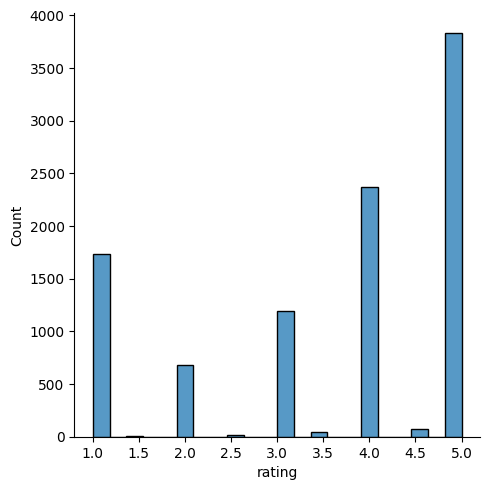

In [ ]:
emb = pd.DataFrame(reviews_embedding)
emb.index = maindataset.index

def properscaler(simio):
 scaler = StandardScaler()
 resultsWordstrans = scaler.fit_transform(simio)
 resultsWordstrans = pd.DataFrame(resultsWordstrans)
 resultsWordstrans.index = simio.index
 resultsWordstrans.columns = simio.columns
 return resultsWordstrans

emb = properscaler(emb)


emb['rating'] = pd.to_numeric(maindataset['Rating'], errors='coerce')
emb = emb.dropna()
sns.displot(emb['rating'])

Split in training and test sets

In [ ]:
outp = train_test_split(emb, train_size=0.7)
finaleval=outp[1]
subset=outp[0]

x_subset = subset.drop(columns=["rating"]).to_numpy()
y_subset = subset['rating'].to_numpy()
x_finaleval = finaleval.drop(columns=["rating"]).to_numpy()
y_finaleval = finaleval[['rating']].to_numpy()
#size of the training set
len(y_subset)

6972

Prepare a neural network for regression.

In [42]:
#initialize
neur = tf.keras.models.Sequential()
#layers
neur.add(tf.keras.layers.Dense(units=150, activation='relu'))
neur.add(tf.keras.layers.Dense(units=250, activation='sigmoid'))
neur.add(tf.keras.layers.Dense(units=700, activation='tanh'))

#output layer / no activation for output of regression
neur.add(tf.keras.layers.Dense(units=1, activation=None))

#using mse for regression. Simple and clear
neur.compile(loss='mse', optimizer='adam', metrics=['mse'])

#train
neur.fit(x_subset, y_subset, batch_size=5000, epochs=1000)

Epoch 1/1000
2/2 [==============================] - 1s 79ms/step - loss: 12.2969 - mse: 12.2969
Epoch 2/1000
2/2 [==============================] - 0s 76ms/step - loss: 8.7129 - mse: 8.7129
Epoch 3/1000
2/2 [==============================] - 0s 82ms/step - loss: 3.3486 - mse: 3.3486
Epoch 4/1000
2/2 [==============================] - 0s 81ms/step - loss: 2.8875 - mse: 2.8875
Epoch 5/1000
2/2 [==============================] - 0s 86ms/step - loss: 4.1015 - mse: 4.1015
Epoch 6/1000
2/2 [==============================] - 0s 80ms/step - loss: 1.4481 - mse: 1.4481
Epoch 7/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.4519 - mse: 1.4519
Epoch 8/1000
2/2 [==============================] - 0s 72ms/step - loss: 2.2173 - mse: 2.2173
Epoch 9/1000
2/2 [==============================] - 0s 81ms/step - loss: 1.1797 - mse: 1.1797
Epoch 10/1000
2/2 [==============================] - 0s 77ms/step - loss: 0.7820 - mse: 0.7820
Epoch 11/1000
2/2 [==============================] - 0s 8

Predict on the test data

In [43]:
test_out = neur.predict(x_finaleval)
test_out

94/94 [==============================] - 0s 3ms/step


array([[4.9352965],
       [3.5846605],
       [1.418678 ],
       ...,
       [3.417655 ],
       [3.8289502],
       [4.77578  ]], dtype=float32)

This step might not be necessary, but I do it in order to be sure that the data is between 1 and 5, as it is in the original set

In [44]:
output = outp[1][[0]]
scal = MinMaxScaler(feature_range=(1,5))
output['predicted'] = scal.fit_transform(test_out)
output['actual'] = y_finaleval
output = output.drop(columns=[0])
output = pd.merge(output, maindataset[['Review']], left_index=True, right_index=True)
output = output.sort_values(['predicted'], ascending=False)
pd.options.display.max_colwidth = 150
output

,predicted,actual,Review
7741,5.000000,5.0,I've been to Squeeze @ The Lime many times with my family. We always enjoy the food here. We like the Ambience. Chef Mr. Dinesh is the best!!
457,4.881617,3.0,Been to OTMBC basing on friends suggestion.Keep reminded that stags r not allowed to ground floor may be on weekends. Disappointing but we made ou...
3357,4.839841,1.0,The DJ that came on around 11 PM yesterday night (some lady) was a terrific disimprovement over the guy who was playing right before she. Killed t...
5582,4.799379,5.0,"I visited Cafe Eclat this morning for brunch. Despite the place being full, the service was exceptional. Food tasted fresh and the ambience was li..."
6414,4.787643,5.0,On time deli
...,...,...,...
1917,1.127210,1.0,Worst biryani they mix normal rice in biryani more than basmati. Ordered fish biryani and it tasted pathetic. It was the first time I ordered and ...
4960,1.043176,1.0,Worst service food. Those who want blood pressure problem may visit. Every thing highly saalted. Don't go on name mathura it's local. Worst food w...
8952,1.026854,1.0,This is the continuous second time that the order is not delivered completely\nNot acceptable
7831,1.010749,1.0,"This is the worst place in Zomato gold I ever visited,waste of money,service is worst and the service Boys can't even open their mouth properly to..."


The results look fine. Now I will examine the stats of the regression

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("R2: ", r2_score(output['actual'], output['predicted']))
print("MeanSqError: ",np.sqrt(mean_squared_error(output['actual'], output['predicted'])))
print("MeanAbsError: ", mean_absolute_error(output['actual'],output['predicted']))

R2:  0.5821113406750714
MeanSqError:  0.9518796829708643
MeanAbsError:  0.8159843193084829


Which are not very good. But the main issue is extracting the bad reviews, so I will proceed to mark those under 2.5 in the scale (1 and 2 in the original)

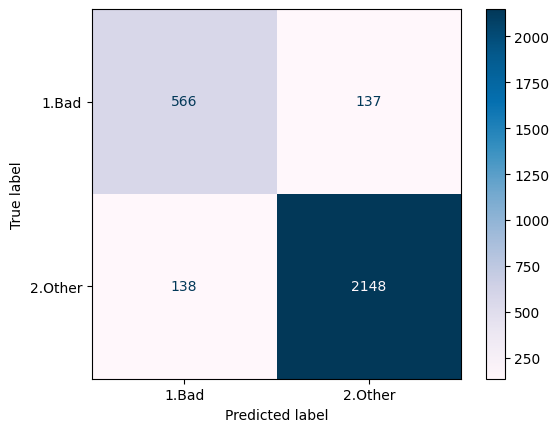

In [46]:
output["RangePredicted"] = np.where(output['predicted']<=2.5,"1.Bad","2.Other")
output["RangeActual"] = np.where(output['actual']<=2.5,"1.Bad","2.Other")

ConfusionMatrixDisplay.from_predictions(y_true=output['RangeActual'] ,y_pred=output['RangePredicted'] , cmap='PuBu')


Now, this data is more useful.